In [48]:
from diffusers.configuration_utils import ConfigMixin, register_to_config
from diffusers import DDPMScheduler
from diffusers.schedulers.scheduling_ddpm import DDPMSchedulerOutput
import torch
import numpy as np
from typing import List, Optional, Tuple, Union
#can you register to diffusers
class DDPMScheduler_Twisted(DDPMScheduler):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.one_minus_alphas_cumprod = 1 - self.alphas_cumprod
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(self.one_minus_alphas_cumprod)
        self.sqrt_alphas = torch.sqrt(self.alphas)
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        
        self.alphas_cumprod_prev = torch.from_numpy(np.append(1.0, self.alphas_cumprod[:-1]))
        self.posterior_mean_coef1 = (
            self.betas * torch.sqrt(self.alphas_cumprod_prev) /
            (1.0 - self.alphas_cumprod)
        )
        self.posterior_mean_coef2 = (
            (1.0 - self.alphas_cumprod_prev) * torch.sqrt(self.alphas) /
            (1.0 - self.alphas_cumprod)
        )
        self.posterior_variance = (
            self.betas * (1.0 - self.alphas_cumprod_prev) /
            (1.0 - self.alphas_cumprod)
        )
        
from typing import List, Optional, Tuple, Union

import torch

from diffusers.utils.torch_utils import randn_tensor
from diffusers.pipelines.pipeline_utils import DiffusionPipeline, ImagePipelineOutput
#import DDPMScheduler
#import gaussian distribution
from torch.distributions.normal import Normal

In [45]:
import numpy as np
from PIL import Image
def load_image_and_convert_to_tensor(image = "/hai/scratch/mli89/protein_design/genie2/sanitycheck/Marvin.jpg"):
    image = Image.open(image)
    #resize the image to 256x256
    image = image.resize((256,256))
    image = np.array(image)
    image = torch.from_numpy(image).permute(2, 0, 1)
    image = (1/255*image - 0.5)*2
    return image
inpaint_part = load_image_and_convert_to_tensor().unsqueeze(0)
top_left, top_right, bottom_left, bottom_right = (50,50,200,200)

inpaint_part_mask = inpaint_part[:,:,top_left:bottom_left, top_right:bottom_right]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8745098..1.0].


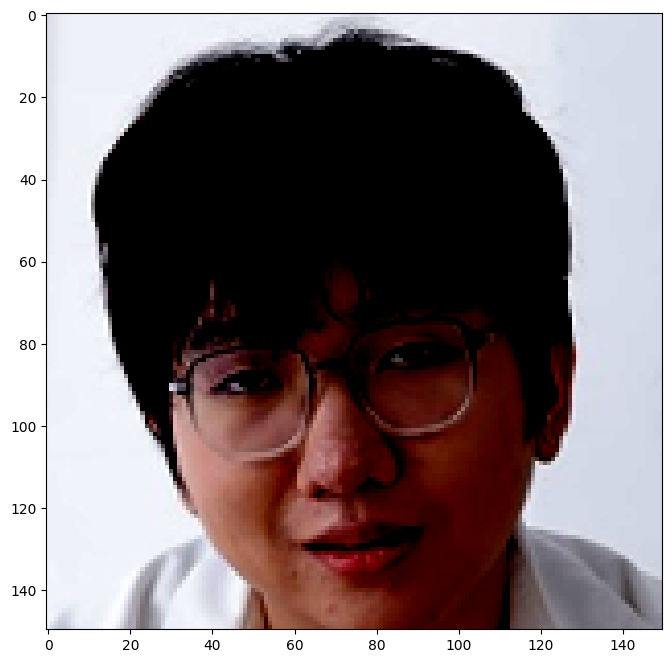

In [46]:
#show the mask
from matplotlib import pyplot as plt
plt.figure(figsize=(8, 8))
plt.imshow(inpaint_part_mask[0].permute(1,2,0).cpu().numpy())
plt.show()

In [58]:
from diffusers.schedulers.scheduling_utils import KarrasDiffusionSchedulers, SchedulerMixin    

class DDPMPipeline(DiffusionPipeline):

    model_cpu_offload_seq = "unet"

    def __init__(self, unet, scheduler):
        super().__init__()
        self.register_modules(unet=unet, scheduler=scheduler)
        
    
    def get_xstart_var(self,alphas_cumprod_t, tausq_=0.05,var_type = 6):
        
        sigmasq_ = (1-alphas_cumprod_t) / alphas_cumprod_t
        if var_type == 1:
            return sigmasq_ 
        elif var_type == 2: # pseudoinverse-guided paper https://openreview.net/forum?id=9_gsMA8MRKQ 
            tausq_ = 1.0 
            return (sigmasq_ * tausq_) / (sigmasq_ + tausq_)
            #return (1 - alphas_cumprod_t) 
        elif var_type == 5: 
            tausq_ = 0.30 
            return (sigmasq_ * tausq_) / (sigmasq_ + tausq_)
        elif var_type == 3: # DPS paper https://arxiv.org/abs/2209.14687 
            return None  
        elif var_type == 4: # pseudoinverse-guided paper -- the actual implementation, see their Alg.1 
            return beta_t  / np.sqrt(alphas_cumprod_t) 
        elif var_type == 6: # freely specify tausq_
            tausq_ = tausq_ 
            return (sigmasq_ * tausq_) / (sigmasq_ + tausq_)       
        
    
    def twisted(
        self,
        batch_size: int = 1,
        generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
        num_inference_steps: int = 10,
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
    ) -> Union[ImagePipelineOutput, Tuple]:
        # Sample gaussian noise to begin loop
                
        
        if isinstance(self.unet.config.sample_size, int):
            image_shape = (
                batch_size,
                self.unet.config.in_channels,
                self.unet.config.sample_size,
                self.unet.config.sample_size,
            )
        else:
            image_shape = (batch_size, self.unet.config.in_channels, *self.unet.config.sample_size)

        if self.device.type == "mps":
            # randn does not work reproducibly on mps
            image = randn_tensor(image_shape, generator=generator, dtype=self.unet.dtype)
            image = image.to(self.device)
        else:
            image = randn_tensor(image_shape, generator=generator, device=self.device, dtype=self.unet.dtype)

        # set step values
        self.scheduler.set_timesteps(num_inference_steps)

        
        def reparametrization(mean, var, reference_shape):
            return torch.randn(reference_shape).to(self.device) * torch.sqrt(var) + mean
        
        def p_title_t(x_0, y, betas_t):
            return Normal(x_0, betas_t.sqrt().to(self.device)).log_prob(y.to(self.device))
        
        
        
        
        grad_pk_with_respect_to_x_t = 0
        image.requires_grad = True
        # predicted_noise = self.unet(image, self.scheduler.timesteps.to(self.device)).sample
        
        # temp = self.scheduler.step(predicted_noise, self.scheduler.timesteps.to(self.device), image, generator=generator)
        # image_t_minus_1 = temp.prev_sample
        # image_t0 = temp.pred_original_sample

        #t
        def current_step(index,timesteps):
            return timesteps[index]
        #t-1
        def prev_step(index,timesteps):
            return timesteps[index+1]
        
        for index, t in enumerate(self.progress_bar(self.scheduler.timesteps)):
            
            t_current = current_step(index,self.scheduler.timesteps)
            t_current_var = self.scheduler._get_variance(t_current)
            try:
                t_prev = prev_step(index,self.scheduler.timesteps)
                t_prev_var = self.scheduler._get_variance(t_prev)
                
            except:
                break
            
            predicted_noise = self.unet(image, t_current).sample
            temp = self.scheduler.step(predicted_noise, t_current, image, generator=generator)
            image_t_minus_1 = temp.prev_sample
            image_t0 = temp.pred_original_sample
            
            log_prob = p_title_t(image_t0[:,:,top_left:bottom_left, top_right:bottom_right], inpaint_part_mask, t_prev_var)
            grad_pk_with_respect_to_x_t = torch.autograd.grad(log_prob.mean(), image)[0]
            
            pred_xstart_var = self.get_xstart_var(self.scheduler.alphas_cumprod[t_prev],var_type = 6, tausq_ = 0.012)
            
            grad_pk_with_respect_to_x_t = 1./pred_xstart_var * grad_pk_with_respect_to_x_t
            
            if t >= 20:
                grad_pk_with_respect_to_x_t = grad_pk_with_respect_to_x_t.clamp(-100,100)
                image_t0 = image_t0 + 0*grad_pk_with_respect_to_x_t
            else:
                image_t0 = image_t0
            # alpha_prod_t = self.scheduler.alphas_cumprod[t_current]
            # alpha_prod_t_prev = self.scheduler.alphas_cumprod[t_prev] if t_prev >= 0 else self.one
            # beta_prod_t = 1 - alpha_prod_t
            # beta_prod_t_prev = 1 - alpha_prod_t_prev
            # current_alpha_t = alpha_prod_t / alpha_prod_t_prev
            # current_beta_t = 1 - current_alpha_t
            
            #pred_original_sample_coeff = (alpha_prod_t_prev ** (0.5) * current_beta_t) / beta_prod_t
            #current_sample_coeff = current_alpha_t ** (0.5) * beta_prod_t_prev / beta_prod_t
            
            
            image_mean = self.scheduler.posterior_mean_coef1[t_prev] * image_t0 + self.scheduler.posterior_mean_coef2[t_prev] * image_t_minus_1
            #image_mean = pred_original_sample_coeff * image_t0.clip(-1,1) + current_sample_coeff * image
            image_var = self.scheduler.posterior_variance[t_prev]
            #sample from normal distribution
            image = torch.randn_like(image) * torch.sqrt(image_var) + image_mean
            
            
            wk = None
            if index % 10 == 0:
                #print(log_prob.sum(axis = [1,2,3]))
                #find mse distance between image_t0 and mask
                mse = torch.nn.functional.mse_loss(image_t0[:,:,top_left:bottom_left, top_right:bottom_right], inpaint_part_mask.cuda(), reduction = "sum")
                print(mse)
            image = image.detach()
            image.requires_grad = True
            
            
            
        

        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
        if output_type == "pil":
            image = self.numpy_to_pil(image)

        if not return_dict:
            return (image,)

        return ImagePipelineOutput(images=image)
    @torch.no_grad()
    def __call__(
        self,
        batch_size: int = 1,
        generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
        num_inference_steps: int = 10,
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
    ) -> Union[ImagePipelineOutput, Tuple]:
        # Sample gaussian noise to begin loop
        if isinstance(self.unet.config.sample_size, int):
            image_shape = (
                batch_size,
                self.unet.config.in_channels,
                self.unet.config.sample_size,
                self.unet.config.sample_size,
            )
        else:
            image_shape = (batch_size, self.unet.config.in_channels, *self.unet.config.sample_size)

        if self.device.type == "mps":
            # randn does not work reproducibly on mps
            image = randn_tensor(image_shape, generator=generator, dtype=self.unet.dtype)
            image = image.to(self.device)
        else:
            image = randn_tensor(image_shape, generator=generator, device=self.device, dtype=self.unet.dtype)

        # set step values
        self.scheduler.set_timesteps(num_inference_steps)

        for t in self.progress_bar(self.scheduler.timesteps):
            # 1. predict noise model_output
            model_output = self.unet(image, t).sample

            # 2. compute previous image: x_t -> x_t-1
            temp = self.scheduler.step(model_output, t, image, generator=generator)
            image = temp.prev_sample
            image_t0 = temp.pred_original_sample

        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.cpu().permute(0, 2, 3, 1).numpy()
        if output_type == "pil":
            image = self.numpy_to_pil(image)

        if not return_dict:
            return (image,)

        return ImagePipelineOutput(images=image)
ddpm = DDPMPipeline.from_pretrained("/hai/scratch/mli89/protein_design/genie2/sanitycheck/ddpm-celebahq-256")
custom_scheduler = DDPMScheduler_Twisted.from_config(ddpm.scheduler.config)
ddpm.scheduler = custom_scheduler
ddpm.to("cuda")
print("moved to gpu")

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]An error occurred while trying to fetch /hai/scratch/mli89/protein_design/genie2/sanitycheck/ddpm-celebahq-256: Error no file named diffusion_pytorch_model.safetensors found in directory /hai/scratch/mli89/protein_design/genie2/sanitycheck/ddpm-celebahq-256.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


Loading pipeline components...: 100%|██████████| 2/2 [00:00<00:00,  6.06it/s]

moved to gpu


In [59]:
image = ddpm.twisted(num_inference_steps = 1000, output_type = "numpy")["images"]

  0%|          | 5/1000 [00:00<00:50, 19.77it/s]

tensor(58251.4180, device='cuda:0', grad_fn=<MseLossBackward0>)


  1%|▏         | 14/1000 [00:00<00:47, 20.82it/s]

tensor(53927.9922, device='cuda:0', grad_fn=<MseLossBackward0>)


  2%|▏         | 23/1000 [00:01<00:46, 21.03it/s]

tensor(57602.9219, device='cuda:0', grad_fn=<MseLossBackward0>)


  3%|▎         | 32/1000 [00:01<00:47, 20.51it/s]

tensor(52738.2773, device='cuda:0', grad_fn=<MseLossBackward0>)


  4%|▍         | 44/1000 [00:02<00:46, 20.50it/s]

tensor(54119.5195, device='cuda:0', grad_fn=<MseLossBackward0>)


  5%|▌         | 53/1000 [00:02<00:46, 20.45it/s]

tensor(54257.0469, device='cuda:0', grad_fn=<MseLossBackward0>)


  6%|▌         | 62/1000 [00:03<00:46, 20.29it/s]

tensor(52432.4414, device='cuda:0', grad_fn=<MseLossBackward0>)


  7%|▋         | 74/1000 [00:03<00:46, 20.10it/s]

tensor(54803.2773, device='cuda:0', grad_fn=<MseLossBackward0>)


  8%|▊         | 83/1000 [00:04<00:45, 20.11it/s]

tensor(57180.2188, device='cuda:0', grad_fn=<MseLossBackward0>)


 10%|▉         | 95/1000 [00:04<00:44, 20.20it/s]

tensor(55002.4219, device='cuda:0', grad_fn=<MseLossBackward0>)


 10%|█         | 104/1000 [00:05<00:44, 20.34it/s]

tensor(52505.1250, device='cuda:0', grad_fn=<MseLossBackward0>)


 11%|█▏        | 114/1000 [00:05<00:46, 19.25it/s]

tensor(53712.5859, device='cuda:0', grad_fn=<MseLossBackward0>)


 12%|█▏        | 124/1000 [00:06<00:43, 20.05it/s]

tensor(54941.1250, device='cuda:0', grad_fn=<MseLossBackward0>)


 13%|█▎        | 133/1000 [00:06<00:42, 20.17it/s]

tensor(55442.6953, device='cuda:0', grad_fn=<MseLossBackward0>)


 14%|█▍        | 144/1000 [00:07<00:43, 19.56it/s]

tensor(54337.2617, device='cuda:0', grad_fn=<MseLossBackward0>)


 15%|█▌        | 153/1000 [00:07<00:41, 20.30it/s]

tensor(53633.1992, device='cuda:0', grad_fn=<MseLossBackward0>)


 16%|█▋        | 165/1000 [00:08<00:40, 20.73it/s]

tensor(53311.6328, device='cuda:0', grad_fn=<MseLossBackward0>)


 17%|█▋        | 174/1000 [00:08<00:39, 20.86it/s]

tensor(51814.2734, device='cuda:0', grad_fn=<MseLossBackward0>)


 18%|█▊        | 183/1000 [00:09<00:40, 20.36it/s]

tensor(54993.2188, device='cuda:0', grad_fn=<MseLossBackward0>)


 20%|█▉        | 195/1000 [00:09<00:38, 20.79it/s]

tensor(56615.4922, device='cuda:0', grad_fn=<MseLossBackward0>)


 20%|██        | 204/1000 [00:10<00:38, 20.54it/s]

tensor(56375.8047, device='cuda:0', grad_fn=<MseLossBackward0>)


 21%|██▏       | 213/1000 [00:10<00:38, 20.42it/s]

tensor(58892.7969, device='cuda:0', grad_fn=<MseLossBackward0>)


 22%|██▎       | 225/1000 [00:11<00:36, 21.20it/s]

tensor(59517.0625, device='cuda:0', grad_fn=<MseLossBackward0>)


 23%|██▎       | 234/1000 [00:11<00:35, 21.42it/s]

tensor(60227.6602, device='cuda:0', grad_fn=<MseLossBackward0>)


 24%|██▍       | 243/1000 [00:11<00:35, 21.21it/s]

tensor(58506.4453, device='cuda:0', grad_fn=<MseLossBackward0>)


 26%|██▌       | 255/1000 [00:12<00:35, 20.87it/s]

tensor(61097.5430, device='cuda:0', grad_fn=<MseLossBackward0>)


 26%|██▋       | 264/1000 [00:12<00:35, 20.46it/s]

tensor(61334.8828, device='cuda:0', grad_fn=<MseLossBackward0>)


 27%|██▋       | 273/1000 [00:13<00:36, 20.18it/s]

tensor(64796.5312, device='cuda:0', grad_fn=<MseLossBackward0>)


 28%|██▊       | 282/1000 [00:13<00:35, 20.25it/s]

tensor(64536.7930, device='cuda:0', grad_fn=<MseLossBackward0>)


 29%|██▉       | 293/1000 [00:14<00:34, 20.29it/s]

tensor(64888.3203, device='cuda:0', grad_fn=<MseLossBackward0>)


 30%|███       | 302/1000 [00:14<00:34, 20.21it/s]

tensor(66343.5078, device='cuda:0', grad_fn=<MseLossBackward0>)


 31%|███▏      | 314/1000 [00:15<00:34, 20.12it/s]

tensor(67890.5156, device='cuda:0', grad_fn=<MseLossBackward0>)


 32%|███▎      | 325/1000 [00:15<00:33, 20.09it/s]

tensor(68134.5078, device='cuda:0', grad_fn=<MseLossBackward0>)


 33%|███▎      | 334/1000 [00:16<00:32, 20.37it/s]

tensor(68064.5469, device='cuda:0', grad_fn=<MseLossBackward0>)


 34%|███▍      | 343/1000 [00:16<00:31, 20.74it/s]

tensor(68373.6562, device='cuda:0', grad_fn=<MseLossBackward0>)


 36%|███▌      | 355/1000 [00:17<00:30, 20.85it/s]

tensor(68488.7969, device='cuda:0', grad_fn=<MseLossBackward0>)


 36%|███▋      | 364/1000 [00:17<00:31, 20.30it/s]

tensor(68840.2969, device='cuda:0', grad_fn=<MseLossBackward0>)


 37%|███▋      | 373/1000 [00:18<00:31, 19.96it/s]

tensor(68767.7188, device='cuda:0', grad_fn=<MseLossBackward0>)


 38%|███▊      | 385/1000 [00:18<00:30, 20.34it/s]

tensor(69005.5000, device='cuda:0', grad_fn=<MseLossBackward0>)


 39%|███▉      | 394/1000 [00:19<00:29, 20.21it/s]

tensor(69234.1562, device='cuda:0', grad_fn=<MseLossBackward0>)


 40%|████      | 403/1000 [00:19<00:29, 20.56it/s]

tensor(69490.5781, device='cuda:0', grad_fn=<MseLossBackward0>)


 41%|████      | 412/1000 [00:20<00:29, 20.00it/s]

tensor(69556.3125, device='cuda:0', grad_fn=<MseLossBackward0>)


 42%|████▎     | 425/1000 [00:20<00:29, 19.49it/s]

tensor(69377.9375, device='cuda:0', grad_fn=<MseLossBackward0>)


 43%|████▎     | 434/1000 [00:21<00:29, 19.48it/s]

tensor(70009.0312, device='cuda:0', grad_fn=<MseLossBackward0>)


 44%|████▍     | 443/1000 [00:21<00:27, 20.24it/s]

tensor(69822.3750, device='cuda:0', grad_fn=<MseLossBackward0>)


 45%|████▌     | 454/1000 [00:22<00:27, 19.83it/s]

tensor(70071.1406, device='cuda:0', grad_fn=<MseLossBackward0>)


 46%|████▌     | 462/1000 [00:22<00:26, 20.09it/s]

tensor(70108.3359, device='cuda:0', grad_fn=<MseLossBackward0>)


 47%|████▋     | 473/1000 [00:23<00:26, 19.79it/s]

tensor(70300.0703, device='cuda:0', grad_fn=<MseLossBackward0>)


 48%|████▊     | 485/1000 [00:23<00:25, 20.19it/s]

tensor(70316.1016, device='cuda:0', grad_fn=<MseLossBackward0>)


 49%|████▉     | 494/1000 [00:24<00:24, 20.46it/s]

tensor(70405.5391, device='cuda:0', grad_fn=<MseLossBackward0>)


 50%|█████     | 503/1000 [00:24<00:24, 20.41it/s]

tensor(70399.6406, device='cuda:0', grad_fn=<MseLossBackward0>)


 52%|█████▏    | 515/1000 [00:25<00:23, 20.71it/s]

tensor(70397.9062, device='cuda:0', grad_fn=<MseLossBackward0>)


 52%|█████▏    | 524/1000 [00:25<00:22, 20.80it/s]

tensor(70411.7656, device='cuda:0', grad_fn=<MseLossBackward0>)


 53%|█████▎    | 533/1000 [00:26<00:23, 20.23it/s]

tensor(70412.4688, device='cuda:0', grad_fn=<MseLossBackward0>)


 55%|█████▍    | 545/1000 [00:26<00:22, 20.44it/s]

tensor(70412.4688, device='cuda:0', grad_fn=<MseLossBackward0>)


 55%|█████▌    | 554/1000 [00:27<00:22, 20.25it/s]

tensor(70412.4688, device='cuda:0', grad_fn=<MseLossBackward0>)


 56%|█████▋    | 565/1000 [00:27<00:21, 20.43it/s]

tensor(70412.4688, device='cuda:0', grad_fn=<MseLossBackward0>)


 57%|█████▋    | 574/1000 [00:28<00:20, 20.53it/s]

tensor(70412.4688, device='cuda:0', grad_fn=<MseLossBackward0>)


 58%|█████▊    | 583/1000 [00:28<00:20, 20.36it/s]

tensor(70412.2969, device='cuda:0', grad_fn=<MseLossBackward0>)


 60%|█████▉    | 595/1000 [00:29<00:19, 20.60it/s]

tensor(70412.3906, device='cuda:0', grad_fn=<MseLossBackward0>)


 60%|██████    | 604/1000 [00:29<00:19, 20.66it/s]

tensor(70412.4688, device='cuda:0', grad_fn=<MseLossBackward0>)


 61%|██████▏   | 613/1000 [00:30<00:18, 20.63it/s]

tensor(70412.4688, device='cuda:0', grad_fn=<MseLossBackward0>)


 62%|██████▎   | 625/1000 [00:30<00:18, 20.41it/s]

tensor(70412.4688, device='cuda:0', grad_fn=<MseLossBackward0>)


 63%|██████▎   | 634/1000 [00:31<00:17, 20.48it/s]

tensor(70412.4688, device='cuda:0', grad_fn=<MseLossBackward0>)


 64%|██████▍   | 643/1000 [00:31<00:17, 20.10it/s]

tensor(70412.4688, device='cuda:0', grad_fn=<MseLossBackward0>)


 66%|██████▌   | 655/1000 [00:32<00:16, 21.30it/s]

tensor(70412.4688, device='cuda:0', grad_fn=<MseLossBackward0>)


 66%|██████▋   | 664/1000 [00:32<00:15, 21.35it/s]

tensor(70412.4688, device='cuda:0', grad_fn=<MseLossBackward0>)


 67%|██████▋   | 673/1000 [00:33<00:15, 21.53it/s]

tensor(70412.4688, device='cuda:0', grad_fn=<MseLossBackward0>)


 68%|██████▊   | 685/1000 [00:33<00:14, 21.63it/s]

tensor(70412.4688, device='cuda:0', grad_fn=<MseLossBackward0>)


 69%|██████▉   | 694/1000 [00:34<00:14, 21.60it/s]

tensor(70412.4688, device='cuda:0', grad_fn=<MseLossBackward0>)


 70%|███████   | 703/1000 [00:34<00:14, 21.10it/s]

tensor(70412.4688, device='cuda:0', grad_fn=<MseLossBackward0>)


 72%|███████▏  | 715/1000 [00:35<00:13, 20.66it/s]

tensor(70412.4688, device='cuda:0', grad_fn=<MseLossBackward0>)


 72%|███████▏  | 724/1000 [00:35<00:13, 20.41it/s]

tensor(70412.4688, device='cuda:0', grad_fn=<MseLossBackward0>)


 73%|███████▎  | 733/1000 [00:35<00:12, 20.67it/s]

tensor(70412.4688, device='cuda:0', grad_fn=<MseLossBackward0>)


 74%|███████▍  | 745/1000 [00:36<00:12, 20.37it/s]

tensor(70412.4688, device='cuda:0', grad_fn=<MseLossBackward0>)


 75%|███████▌  | 754/1000 [00:36<00:12, 20.10it/s]

tensor(70412.4688, device='cuda:0', grad_fn=<MseLossBackward0>)


 76%|███████▋  | 763/1000 [00:37<00:11, 20.31it/s]

tensor(70412.4688, device='cuda:0', grad_fn=<MseLossBackward0>)


 78%|███████▊  | 775/1000 [00:38<00:11, 20.25it/s]

tensor(70412.2812, device='cuda:0', grad_fn=<MseLossBackward0>)


 78%|███████▊  | 784/1000 [00:38<00:10, 20.18it/s]

tensor(70411.9609, device='cuda:0', grad_fn=<MseLossBackward0>)


 79%|███████▉  | 793/1000 [00:38<00:10, 20.29it/s]

tensor(70411.3203, device='cuda:0', grad_fn=<MseLossBackward0>)


 80%|████████  | 805/1000 [00:39<00:09, 21.16it/s]

tensor(70411.1250, device='cuda:0', grad_fn=<MseLossBackward0>)


 81%|████████▏ | 814/1000 [00:39<00:08, 21.16it/s]

tensor(70409.1797, device='cuda:0', grad_fn=<MseLossBackward0>)


 82%|████████▏ | 823/1000 [00:40<00:08, 20.75it/s]

tensor(70405.7500, device='cuda:0', grad_fn=<MseLossBackward0>)


 84%|████████▎ | 835/1000 [00:40<00:07, 20.69it/s]

tensor(70403.2188, device='cuda:0', grad_fn=<MseLossBackward0>)


 84%|████████▍ | 844/1000 [00:41<00:07, 20.64it/s]

tensor(70398.5781, device='cuda:0', grad_fn=<MseLossBackward0>)


 85%|████████▌ | 853/1000 [00:41<00:07, 20.61it/s]

tensor(70390.6875, device='cuda:0', grad_fn=<MseLossBackward0>)


 86%|████████▋ | 865/1000 [00:42<00:06, 20.42it/s]

tensor(70376.1094, device='cuda:0', grad_fn=<MseLossBackward0>)


 87%|████████▋ | 874/1000 [00:42<00:06, 20.06it/s]

tensor(70359.7031, device='cuda:0', grad_fn=<MseLossBackward0>)


 88%|████████▊ | 883/1000 [00:43<00:05, 20.13it/s]

tensor(70340.5859, device='cuda:0', grad_fn=<MseLossBackward0>)


 90%|████████▉ | 895/1000 [00:43<00:05, 20.28it/s]

tensor(70322.1875, device='cuda:0', grad_fn=<MseLossBackward0>)


 90%|█████████ | 904/1000 [00:44<00:04, 20.28it/s]

tensor(70292.4297, device='cuda:0', grad_fn=<MseLossBackward0>)


 91%|█████████▏| 913/1000 [00:44<00:04, 20.32it/s]

tensor(70257.0625, device='cuda:0', grad_fn=<MseLossBackward0>)


 92%|█████████▎| 925/1000 [00:45<00:03, 20.39it/s]

tensor(70204.8594, device='cuda:0', grad_fn=<MseLossBackward0>)


 93%|█████████▎| 934/1000 [00:45<00:03, 20.22it/s]

tensor(70135.9609, device='cuda:0', grad_fn=<MseLossBackward0>)


 94%|█████████▍| 943/1000 [00:46<00:02, 20.04it/s]

tensor(70091.1719, device='cuda:0', grad_fn=<MseLossBackward0>)


 96%|█████████▌| 955/1000 [00:46<00:02, 20.39it/s]

tensor(70037.2734, device='cuda:0', grad_fn=<MseLossBackward0>)


 96%|█████████▋| 964/1000 [00:47<00:01, 19.87it/s]

tensor(69953.5156, device='cuda:0', grad_fn=<MseLossBackward0>)


 98%|█████████▊| 975/1000 [00:47<00:01, 20.07it/s]

tensor(69884.2969, device='cuda:0', grad_fn=<MseLossBackward0>)


 98%|█████████▊| 984/1000 [00:48<00:00, 20.25it/s]

tensor(69801.8516, device='cuda:0', grad_fn=<MseLossBackward0>)


 99%|█████████▉| 994/1000 [00:48<00:00, 20.05it/s]

tensor(69776.2266, device='cuda:0', grad_fn=<MseLossBackward0>)


100%|█████████▉| 999/1000 [00:49<00:00, 20.36it/s]


In [60]:
image.max(), image.min()

(np.float32(0.99991703), np.float32(0.9759167))

In [56]:
image.shape

(1, 256, 256, 3)

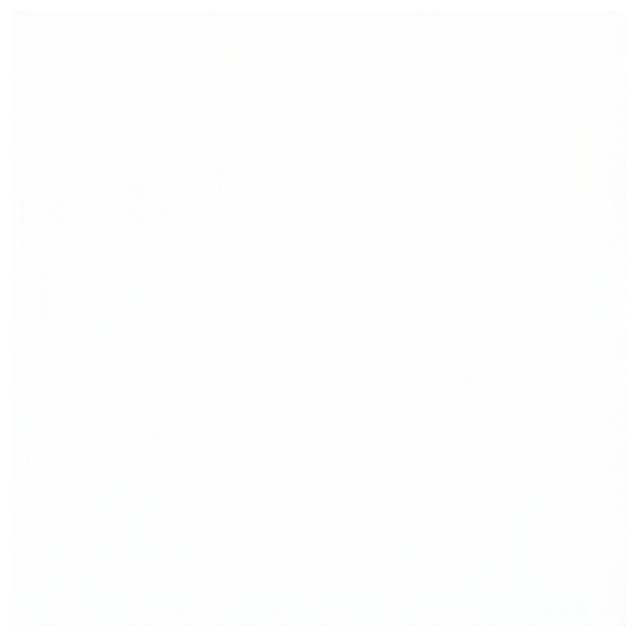

In [61]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.imshow(image[0])
plt.axis('off')
plt.show()